# 한영 번역기 만들기

## 프로젝트 설명

영어 문장을 입력했을 때 한국어 문장으로 번역해주는 번역 모델 학습

seq2seq 모델에 영어-한국어 문장 데이터를 학습시켜 번역기를 만든다.

노드에서 제공하는 코드는 영어-스페인어 번역기를 만드는 프로젝트이다. (입력이 영어 문장이고 출력이 번역된 스페인어 문장)

전체 코드를 유사하게 사용하되 다른 데이터를 사용하기로 결정하였다.

```python
# 데이터 디렉토리 구조
datasets
├── spa-eng
│   ├── spa-eng.zip
│   └── spa-eng
│       ├── _about.txt
│       └── spa.txt
└── kor-eng
    ├── kor-eng.zip
    └── kor-eng
        ├── _about.txt
        └── kor.txt
```

- 추가로 동일 사이트에서 파일 이름만 kor-eng.zip으로 변경했을 때 에러가 발생하여 새로운 사이트를 찾아서 진행하였다.
- spa-eng.zip을 포함한 다양한 언어 쌍 데이터를 모아둔 사이트
    
    [Tab-delimited Bilingual Sentence Pairs](https://www.manythings.org/anki/)
    
- 위 사이트에서 제공하는 데이터는 attribution column이 추가되어 있어 노드에서 제공하는 데이터와 동일하게 만들기 위해서는 데이터를 읽어올 때 attribution까지 추가해서 불러온 뒤 attribution column을 drop 시켜야 한다.

- 한국어 형태소 분석기로는 Mecab을 사용하고 전처리 또한 진행하기로 했다.

## 프로젝트 루브릭

| 학습목표 | 평가기준 |
|----------|-----------|
| 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다. | 구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다. |
| Attentional Seq2seq 모델이 정상적으로 구동된다. | seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다. |
| 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다. | 테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다. |

# 사전 환경 세팅

## 환경 세팅

In [154]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/AIFFEL/Deep_Dive/
# !mkdir -p ./work/s2s_translation

In [155]:
# !sudo apt-get update
# !sudo apt-get install -y fonts-nanum fonts-noto-cjk
# !fc-list | grep -i "nanum\|noto"
!pip install sentencepiece
# !pip install konlpy
# !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# %cd ./Mecab-ko-for-Google-Colab/
# !bash install_mecab-ko_on_colab_light_220429.sh
# %cd /content/drive/MyDrive/AIFFEL/Deep_Dive/work/s2s_translation

Defaulting to user installation because normal site-packages is not writeable


# 라이브러리 설치 및 호출

## 라이브러리 호출

In [156]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import logging

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

font_path = r"C:/Windows/Fonts/malgun.ttf"
fontprop = fm.FontProperties(fname=font_path, size=12)
plt.rcParams['font.family'] = 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False

print(f"설정된 폰트: {fontprop.get_name()}")

설정된 폰트: Malgun Gothic


In [157]:
import os
import re
import urllib.request
import zipfile
import sentencepiece as spm
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)

2.9.0+cpu


# 데이터 분석

## 데이터 다운로드 및 열기

In [158]:
dataset_dir = os.path.join(os.path.expanduser("./datasets"), "kor-eng")
os.makedirs(dataset_dir, exist_ok=True)
zip_path = os.path.join(dataset_dir, "kor-eng.zip")

if not os.path.exists(zip_path):
    print("데이터 다운로드 중...")
    # url = "https://www.manythings.org/anki/spa-eng.zip"
    url = "https://www.manythings.org/anki/kor-eng.zip"
    urllib.request.urlretrieve(url, zip_path)
    print("다운로드 완료!")

data_folder = os.path.join(dataset_dir, "kor-eng")
if not os.path.exists(data_folder):
    print("압축 해제 중...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)
    print("압축 해제 완료!")

path_to_file = os.path.join(data_folder, "kor.txt")

print("데이터셋 디렉토리:", os.listdir(dataset_dir))

데이터셋 디렉토리: ['kor-eng', 'kor-eng.zip']


## 데이터 확인하기

In [159]:
df = pd.read_csv(path_to_file, sep = "\t", names = ["eng", "kor", "attribution"]).drop(columns=["attribution"])
df.head()

,eng,kor
0,Go.,가.
1,Hi.,안녕.
2,Run!,뛰어!
3,Run.,뛰어.
4,Who?,누구?


# 데이터 전처리

- 문장 단위 전처리 함수 정의
    - 반복되는 문장 부호 제거
    - 맞춤법 변형 통일
    - 반복 문자 제거
    - 완성형 한글 필터링
    - 이모지, 이모티콘, 특수문자 제거
    - 영어 소문자 변환
    - 연속 공백 하나의 공백으로 치환
    - 앞뒤 공백 제거
    - 등등
- tokenizer 결정 및 데이터 토큰화
- stopword 정의
- max_len 결정

In [160]:
import re

def preprocess_sentence(text):
    """
    텍스트 전처리 함수
    """
    if pd.isna(text):
        return ""

    text = text.lower().strip()

    text = str(text)

    # 1. 반복되는 문장 부호 제거 (2개 이상 → 1개)
    text = re.sub(r'([.!?…;])\1+', r'\1', text)

    # 2. 영어/숫자/한글/문장부호만 남기고 모두 삭제
    # 이모지, 이모티콘, 특수문자 자동 제거
    text = re.sub(r"[^가-힣a-zA-Z\u00C0-\u024F0-9\s.!?,']", ' ', text)

    # 3. 문장부호 앞뒤로 공백 추가
    text = re.sub(r"([.!?,'])", r' \1 ', text)

    # 4. 연속 공백을 하나의 공백으로 교체
    text = re.sub(r'[" "]+', " ", text)

    # 5. 앞뒤 공백 제거
    text = text.strip()

    return text

In [161]:
#df = df[:30000]

df["eng"] = df["eng"].apply(preprocess_sentence)
df["kor"] = df["kor"].apply(lambda x: preprocess_sentence(x))

df.head()

,eng,kor
0,go .,가 .
1,hi .,안녕 .
2,run !,뛰어 !
3,run .,뛰어 .
4,who ?,누구 ?


# 토큰화

In [162]:
# df["eng"].to_csv("eng_corpus.txt", index=False, header=False, sep="\n", encoding="utf-8")
# df["kor"].to_csv("kor_corpus.txt", index=False, header=False, sep="\n", encoding="utf-8")

df["eng"].to_csv("eng_corpus.txt", index=False, header=False, lineterminator="\n", encoding="utf-8")
df["kor"].to_csv("kor_corpus.txt", index=False, header=False, lineterminator="\n", encoding="utf-8")

print("파일 저장 완료: eng_corpus.txt, kor_corpus.txt")

파일 저장 완료: eng_corpus.txt, kor_corpus.txt


In [163]:
vocab_size = 2380 # 10285
pad_id = 0
bos_id = 1
eos_id = 2
unk_id = 3
model_type = "unigram" # "bpe"

spm.SentencePieceTrainer.train(
    input = "eng_corpus.txt",
    model_prefix = "encoder_spm_"+model_type,
    vocab_size = vocab_size,
    model_type=model_type,
    pad_id = pad_id,
    bos_id = bos_id,
    eos_id = eos_id,
    unk_id = unk_id
)

spm.SentencePieceTrainer.train(
    input = "kor_corpus.txt",
    model_prefix = "decoder_spm_"+model_type,
    vocab_size = vocab_size,
    model_type=model_type,
    pad_id = pad_id,
    bos_id = bos_id,
    eos_id = eos_id,
    unk_id = unk_id
)

In [164]:
encoder_model = "encoder_spm_"+model_type+".model"
encoder_tokenizer = spm.SentencePieceProcessor()
encoder_tokenizer.load(encoder_model)

decoder_model = "decoder_spm_"+model_type+".model"
decoder_tokenizer = spm.SentencePieceProcessor()
decoder_tokenizer.load(decoder_model)

True

In [165]:
df

,eng,kor
0,go .,가 .
1,hi .,안녕 .
2,run !,뛰어 !
3,run .,뛰어 .
4,who ?,누구 ?
...,...,...
6376,i started a new blog . i ' ll do my best not t...,난 블로그를 시작했어 . 블로그를 초반에만 반짝 많이 하다가 관두는 사람처럼은 되지...
6377,i think it ' s a shame that some foreign langu...,몇몇 외국어 선생님이 한 번도 원어민과 공부해본 적도 없으면서 대학을 나올 수 있었...
6378,and the good news is that today the economy is...,"다음으로 좋은 소식은 오늘 경제가 재성장한다는 것입니다 . 임금 , 소득 , 집값 ..."
6379,if someone who doesn ' t know your background ...,만일 네 사정도 잘 모르는 사람이 원어민 같다고 말한다면 그건 그 사람이 네가 원어...


In [166]:
eng_sample = df["eng"][5000]
kor_sample = df["kor"][5000]
print(eng_sample)
print(kor_sample)

i ' m glad that you ' re back in boston .
네가 보스턴으로 돌아와서 기쁘다 .


In [167]:
enc_token = encoder_tokenizer.encode(eng_sample)
enc_token = [encoder_tokenizer.bos_id()] + enc_token + [encoder_tokenizer.eos_id()]
enc_token

[1, 6, 5, 7, 26, 928, 27, 10, 34, 12, 5, 7, 65, 242, 28, 95, 169, 4, 2]

In [168]:
enc_decoding = encoder_tokenizer.decode(enc_token)
enc_decoding

"i ' m glad that you ' re back in boston ."

In [169]:
class TranslationDataset(Dataset):
    def __init__(self, data, encoder_tokenizer, decoder_tokenizer, max_len):
        self.data = data
        self.encoder_tokenizer = encoder_tokenizer
        self.decoder_tokenizer = decoder_tokenizer
        self.max_len = max_len
        self.pad_id = 0
        self.bos_id = 1
        self.eos_id = 2

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src_text = self.data.iloc[idx]['eng']
        trg_text = self.data.iloc[idx]['kor']

        src_ids = self.encoder_tokenizer.encode(src_text)
        trg_ids = self.decoder_tokenizer.encode(trg_text)

        src_ids = src_ids[:self.max_len]

        # Decoder의 입력에는 START_TOKEN과 END_TOKEN을 추가해줍니다. 단, 최대 길이 제한을 적용시킵니다.
        trg_input = [self.bos_id] + trg_ids[:self.max_len - 2] + [self.eos_id]
        trg_label = trg_ids[:self.max_len - 1] + [self.eos_id]

        # # 길이가 짧은 경우 PAD_TOKEN을 추가해줍니다.
        # src_ids = src_ids + [self.pad_id] * (self.max_len - len(src_ids))
        # trg_input = trg_input + [self.pad_id] * (self.max_len - len(trg_input))
        # trg_label = trg_label + [self.pad_id] * (self.max_len - len(trg_label))
        # pre-padding 으로 문장 앞에 PAD_TOKEN 추가
        src_ids = src_ids + [self.pad_id] * (self.max_len - len(src_ids))
        trg_input = trg_input + [self.pad_id] * (self.max_len - len(trg_input))
        trg_label = trg_label + [self.pad_id] * (self.max_len - len(trg_label))

        return torch.tensor(src_ids), torch.tensor(trg_input), torch.tensor(trg_label)

In [170]:
train_ratio = 0.8  # 전체 길이의 80%
MAX_LEN = 40 # 임의의 값
BATCH_SIZE = 64

train_data = df.sample(frac=train_ratio, random_state=42)  # 70% 훈련 데이터
valid_data = df.drop(train_data.index)

train_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)

train_data = TranslationDataset(train_data, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)
validataion_data = TranslationDataset(valid_data, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validataion_data, batch_size=BATCH_SIZE, shuffle=False)

In [171]:
for src, trg_input, trg_label in train_loader:
    print(src.shape, trg_input.shape, trg_label.shape)
    break

# src, trg_imput, trg_label 전부 transpose 필요

torch.Size([64, 40]) torch.Size([64, 40]) torch.Size([64, 40])


# 모델 구현

In [172]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        self.W1 = nn.Linear(hidden_dim, hidden_dim)
        self.W2 = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: (batch_size, hidden_dim)
        # encoder_outputs: (src_len, batch_size, hidden_dim)

        src_len = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1) # (batch_size, 1, hidden_dim)
        hidden = hidden.repeat(1, src_len, 1)  # (batch_size, src_len, hidden_dim)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # (batch_size, src_len, hidden_dim)

        energy = torch.tanh(self.W1(encoder_outputs) + self.W2(hidden))  # (batch_size, src_len, hidden_dim)
        temp = self.v(energy) # (batch_size, src_len, 1)
        attention = temp.squeeze(2)  # (batch_size, src_len)

        return nn.functional.softmax(attention, dim=1)  # (batch_size, src_len)

In [173]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, dropout=0.3):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.GRU(emb_dim, hidden_dim)

    def forward(self, src):
        # src : (src_len, batch_size) -> transpose 후 input으로 사용됨.
        embedded = self.embedding(src)  # embedded : (src_len, batch_size, emb_dim)
        embedded = self.dropout(embedded)
        outputs, hidden = self.rnn(embedded)  # outputs : (src_len, batch_size, hidden_dim), hidden : (1 ,batch_size, hidden_dim)

        return outputs, hidden


In [174]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, attention, dropout=0.3):
        super(Decoder, self).__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.dropout = nn.Dropout(dropout)
        # Decoder RNN에는 embedding만 입력
        self.rnn = nn.GRU(emb_dim+hidden_dim, hidden_dim)
        # 출력층에는 hidden state와 attention value가 결합되어 입력
        self.fc_out = nn.Linear(emb_dim + 2*hidden_dim, output_dim)

    def forward(self, input, hidden, encoder_outputs):
        # input : (batch_size, 1)
        # hidden : (1, batch_size, hidden_dim)
        # encoder_outputs : (src_len, batch_size, hidden_dim)
        input = input.unsqueeze(0)  # input : (1, batch_size)
        embedded = self.embedding(input)  # embedded : (1, batch_size, emb_dim)
        embedded = self.dropout(embedded)

        # attention distribution을 계산합니다. decoder의 이전 hidden state, s_{t-1}와 encoder의 H가 입력됩니다.
        a = self.attention(hidden[-1], encoder_outputs)  # hidden[-1] : (batch_size,  hidden_dim), a : (batch_size, src_len)

        # H에 가중치를 부여해 attention value(Context vector) 계산
        a = a.unsqueeze(1)  # a : (batch_size, 1, src_len)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # encoder_outputs : (batch_size, src_len, hidden_dim)
        context = torch.bmm(a, encoder_outputs)  # context : (batch_size, 1, hidden_dim) # query와 hidden state의 내적
        context = context.permute(1, 0, 2)  # context : (1, batch_size, hidden_dim)

        output, hidden = self.rnn(torch.cat((embedded, context), dim=2), hidden) # output : (1, batch_size, hidden_dim), hidden : (1, batch_size, hidden_dim)

        # 출력층에서는 현재 hidden state와 context vector를 결합하여 예측값 생성
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)  # output : (batch_size, hidden_dim)
        context = context.squeeze(0)  # context : (batch_size, hidden_dim)
        prediction = self.fc_out(torch.cat((output, context, embedded), dim=1))  # (batch_size, output_dim)

        return prediction, hidden, a.squeeze(1)

In [175]:
class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg=None, teacher_forcing_ratio=0.5, max_len=30, bos_id = 1, eos_id=2):
        # 학습 모드에서는 trg_len 사용, 추론 모드에서는 max_len까지 동적 생성
        batch_size = src.shape[1]
        trg_vocab_size = self.decoder.fc_out.out_features

        # 조기 종료를 위해 tensor가 아닌 리스트 사용
        outputs = []

        # 시각화를 위해 attention 저장
        attentions = []

        # 인코더를 통해 context 생성
        encoder_outputs, hidden = self.encoder(src)

        if trg is not None:
            for t in range(0, trg.shape[0]):
                input = trg[t]
                output, hidden, attention = self.decoder(input, hidden, encoder_outputs)
                outputs.append(output.unsqueeze(0))
                attentions.append(attention.unsqueeze(0))
                # teacher forcing 추가
                teacher_force = random.random() < teacher_forcing_ratio
                top1 = output.argmax(1)
                input = trg[t] if teacher_force else top1


        else:
		    # inference에서는 target(정답)이 없기 때문에 sos_token을 생성해줍니다.
            input = torch.full((batch_size,), bos_id, dtype=torch.long, device=self.device)
            finished = torch.zeros(batch_size, dtype=torch.bool, device=self.device)

            for t in range(max_len):
                output, hidden, attention = self.decoder(input, hidden,  encoder_outputs)
                outputs.append(output.unsqueeze(0))
                attentions.append(attention.unsqueeze(0))
                top1 = output.argmax(1)
                input = top1

                # 조기 종료 조건
                finished |= (top1 == eos_id)
                if finished.all():
                    break

        outputs = torch.cat(outputs, dim=0)  # (trg_len, batch_size, output_dim)
        attentions = torch.cat(attentions, dim=0)  # (trg_len, batch_size, src_len)

        return outputs, attentions

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = len(encoder_tokenizer)
output_dim = len(decoder_tokenizer)
emb_dim = 512 # 256
hid_dim = 1024 # 512
dropout = 0.9
lr=5e-4

In [177]:
encoder = Encoder(input_dim, emb_dim, hid_dim, dropout=dropout).to(device)
attention = BahdanauAttention(hid_dim).to(device)
decoder = Decoder(output_dim, emb_dim, hid_dim, attention, dropout=dropout).to(device)
model = Seq2SeqAttention(encoder, decoder, device).to(device)

In [178]:
print(model)

Seq2SeqAttention(
  (encoder): Encoder(
    (embedding): Embedding(2380, 512)
    (dropout): Dropout(p=0.9, inplace=False)
    (rnn): GRU(512, 1024)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (W1): Linear(in_features=1024, out_features=1024, bias=True)
      (W2): Linear(in_features=1024, out_features=1024, bias=True)
      (v): Linear(in_features=1024, out_features=1, bias=False)
    )
    (embedding): Embedding(2380, 512)
    (dropout): Dropout(p=0.9, inplace=False)
    (rnn): GRU(1536, 1024)
    (fc_out): Linear(in_features=2560, out_features=2380, bias=True)
  )
)


# 모델 학습 함수 정의

## Optimizer & Loss 정의

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)

## dataloader 정의

## train 함수 정의

In [180]:
def train_step(model, data_loader, optimizer, criterion, epoch):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    total_tokens = 0

    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}", leave=True)

    for src, trg_input, trg_label in progress_bar:
        src = src.transpose(0, 1).to(device)
        trg_input = trg_input.transpose(0, 1).to(device)
        trg_label = trg_label.transpose(0, 1).to(device)

        optimizer.zero_grad()
        outputs, _ = model(src, trg_input)

        # (trg_len, batch_size, output_dim) → (batch_size * trg_len, output_dim)
        outputs = outputs.view(-1, outputs.shape[-1])
        trg_label = trg_label.reshape(-1)

        loss = criterion(outputs, trg_label)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()

        epoch_loss += loss.item()

        # ===== accuracy 계산 =====
        pred = outputs.argmax(dim=1)          # 예측값
        correct = (pred == trg_label).sum().item()
        epoch_acc += correct
        total_tokens += trg_label.size(0)

        progress_bar.set_postfix(loss=loss.item(),
                                 acc=(epoch_acc / total_tokens))

    return epoch_loss / len(data_loader), epoch_acc / total_tokens

## validation 함수 정의

In [181]:
def eval_step(model, data_loader, optimizer, criterion):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_tokens = 0

    with torch.no_grad():
        for src, trg_input, trg_label in data_loader:
            src = src.transpose(0, 1).to(device)
            trg_input = trg_input.transpose(0, 1).to(device)
            trg_label = trg_label.transpose(0, 1).to(device)

            outputs, _ = model(src, trg_input)

            outputs = outputs.view(-1, outputs.shape[-1])
            trg_label = trg_label.reshape(-1)

            loss = criterion(outputs, trg_label)
            total_loss += loss.item()

            # ===== accuracy 계산 =====
            pred = outputs.argmax(dim=1)
            correct = (pred == trg_label).sum().item()
            total_acc += correct
            total_tokens += trg_label.size(0)

    return total_loss / len(data_loader), total_acc / total_tokens

## 모델 평가 지표 함수 정의

In [182]:
def evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=30):
    model.eval()

    sentence = preprocess_sentence(sentence)
    src_ids = encoder_tokenizer.encode(sentence)
    src_ids = src_ids[:max_len]
    # src_ids = src_ids + [0] * (max_len - len(src_ids))  # 패딩 추가
    src_ids = [0] * (max_len - len(src_ids)) + src_ids
    src_tensor = torch.tensor(src_ids).unsqueeze(1).to(device)  # (src_len, 1)

    with torch.no_grad():
        outputs, attentions = model(src_tensor, max_len=max_len)

    result = [decoder_tokenizer.decode([token.item()]) for token in outputs.argmax(2).squeeze(1)]

    if "<end>" in result:
        result = result[:result.index("<end>")]

    return result, sentence, attentions.squeeze(1).cpu().numpy()

## 시각화 함수 정의

In [183]:
def plot_attention(attention, sentence, predicted_sentence):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticks(range(len(sentence)))
    ax.set_xticklabels(sentence,
                       fontdict=fontdict,
                       rotation=90,
                       fontproperties=fontprop)   # ★ 요기!

    ax.set_yticks(range(len(predicted_sentence)))
    ax.set_yticklabels(predicted_sentence,
                       fontdict=fontdict,
                       fontproperties=fontprop)   # ★ 요기도!

In [184]:
def translate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=30):
    result, sentence, attention = evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    # Attention 크기 조정 (trg_len, src_len)
    attention = attention[:len(result), :len(sentence.split())]

    plot_attention(attention, sentence.split(), result)

# 모델 학습

In [ ]:
%%time

EPOCHS = 20
df_result = pd.DataFrame(columns = ['Train_Acc', 'Train_Loss', 'Valid_Acc', 'Valid_Loss'])

for epoch in range(EPOCHS):
    train_loss, train_acc = train_step(model, train_loader, optimizer, criterion, epoch)
    valid_loss, valid_acc = eval_step(model, validation_loader, optimizer, criterion)
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')
    df_result.loc[epoch] = [train_acc, train_loss, valid_acc, valid_loss]

file_name = "history_s2s_SentencePiece_Unigram_Epochs_" + str(EPOCHS) + "_MaxLen_" + str(MAX_LEN) + "_lr" + str(lr) + "_dropout" + str(dropout)+".csv"
df_result.to_csv(file_name, index=False)


Epoch 1: 100%|██████████| 80/80 [06:58<00:00,  5.23s/it, acc=0.053, loss=5.12]  


Epoch 1/20, Train Loss: 5.4037, Validation Loss: 4.7532


Epoch 2: 100%|██████████| 80/80 [06:54<00:00,  5.18s/it, acc=0.0683, loss=4.57]


Epoch 2/20, Train Loss: 4.7157, Validation Loss: 4.5314


Epoch 3: 100%|██████████| 80/80 [06:54<00:00,  5.18s/it, acc=0.0747, loss=4.14]


Epoch 3/20, Train Loss: 4.4203, Validation Loss: 4.2217


Epoch 4: 100%|██████████| 80/80 [06:46<00:00,  5.09s/it, acc=0.0797, loss=4.41]


Epoch 4/20, Train Loss: 4.1612, Validation Loss: 4.0818


Epoch 5: 100%|██████████| 80/80 [06:37<00:00,  4.97s/it, acc=0.0823, loss=3.95]


Epoch 5/20, Train Loss: 3.9687, Validation Loss: 3.9798


Epoch 6: 100%|██████████| 80/80 [06:36<00:00,  4.96s/it, acc=0.0855, loss=3.73]


Epoch 6/20, Train Loss: 3.7726, Validation Loss: 3.9057


Epoch 7: 100%|██████████| 80/80 [06:38<00:00,  4.99s/it, acc=0.0888, loss=3.62]


Epoch 7/20, Train Loss: 3.6056, Validation Loss: 3.8713


Epoch 8: 100%|██████████| 80/80 [06:47<00:00,  5.10s/it, acc=0.092, loss=3.57] 


Epoch 8/20, Train Loss: 3.4354, Validation Loss: 3.8339


Epoch 9: 100%|██████████| 80/80 [06:39<00:00,  4.99s/it, acc=0.095, loss=3.28] 


Epoch 9/20, Train Loss: 3.2889, Validation Loss: 3.7948


Epoch 10: 100%|██████████| 80/80 [06:10<00:00,  4.63s/it, acc=0.0977, loss=3.44]


Epoch 10/20, Train Loss: 3.1509, Validation Loss: 3.7786


Epoch 11: 100%|██████████| 80/80 [06:38<00:00,  4.98s/it, acc=0.102, loss=3.1] 


Epoch 11/20, Train Loss: 2.9985, Validation Loss: 3.7970


Epoch 12: 100%|██████████| 80/80 [06:47<00:00,  5.09s/it, acc=0.106, loss=3.14]


Epoch 12/20, Train Loss: 2.8678, Validation Loss: 3.7527


Epoch 13: 100%|██████████| 80/80 [06:30<00:00,  4.88s/it, acc=0.109, loss=2.75]


Epoch 13/20, Train Loss: 2.7444, Validation Loss: 3.7677


Epoch 14: 100%|██████████| 80/80 [06:42<00:00,  5.03s/it, acc=0.113, loss=2.62]


Epoch 14/20, Train Loss: 2.6249, Validation Loss: 3.7561


Epoch 15: 100%|██████████| 80/80 [06:46<00:00,  5.09s/it, acc=0.116, loss=2.49]


Epoch 15/20, Train Loss: 2.5174, Validation Loss: 3.7490


Epoch 16: 100%|██████████| 80/80 [06:47<00:00,  5.09s/it, acc=0.12, loss=2.48] 


Epoch 16/20, Train Loss: 2.4128, Validation Loss: 3.7663


Epoch 17: 100%|██████████| 80/80 [06:36<00:00,  4.96s/it, acc=0.124, loss=2.42]


Epoch 17/20, Train Loss: 2.3088, Validation Loss: 3.7749


Epoch 18: 100%|██████████| 80/80 [06:28<00:00,  4.85s/it, acc=0.128, loss=2.43]


Epoch 18/20, Train Loss: 2.2113, Validation Loss: 3.8025


Epoch 19: 100%|██████████| 80/80 [06:26<00:00,  4.83s/it, acc=0.132, loss=2.16]


Epoch 19/20, Train Loss: 2.1197, Validation Loss: 3.7844


Epoch 20: 100%|██████████| 80/80 [06:26<00:00,  4.84s/it, acc=0.135, loss=2.11]


Epoch 20/20, Train Loss: 2.0408, Validation Loss: 3.8011
CPU times: total: 14h 14min 35s
Wall time: 2h 24min 3s


# 결과

Input: he is the most powerful man all over the world .
Predicted translation: ['', '걔', '는', '', '꼴', '찌', '에', '', '꼴', '찌', '한', '사람이', '야', '.', '']


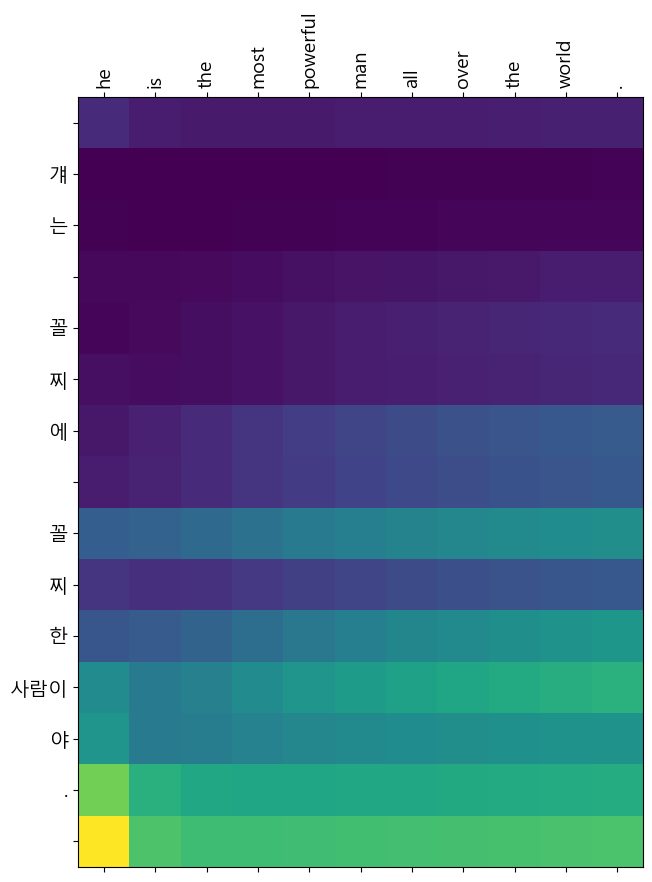

In [186]:
translate("He is the most powerful man all over the world.", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

Input: may i help you ?
Predicted translation: ['', '널', '어', '?', '']


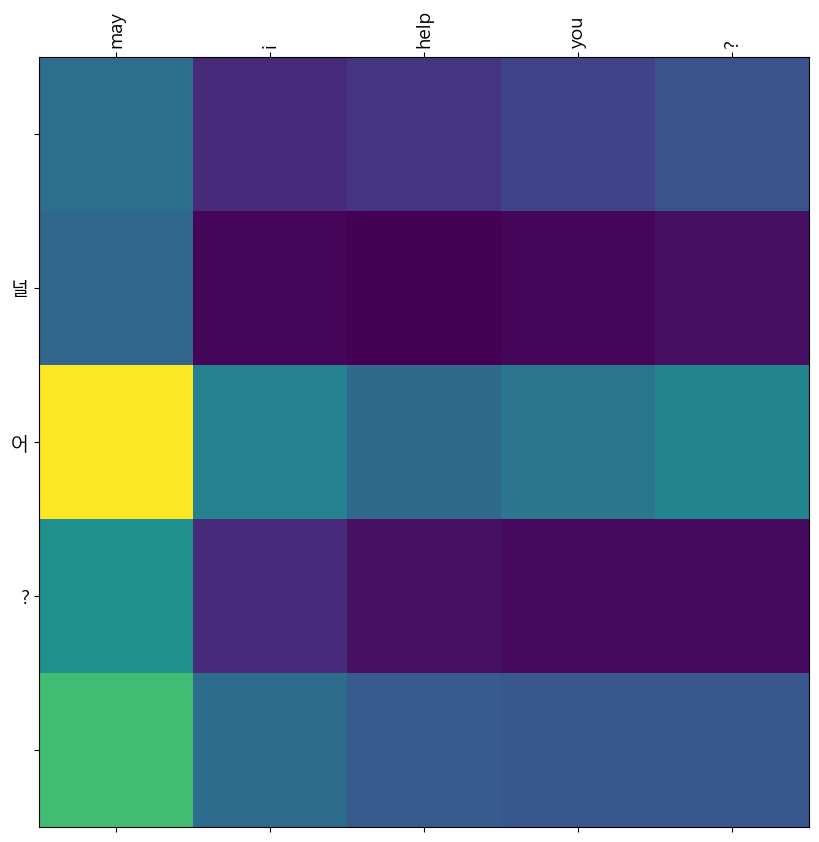

In [187]:
translate("May I help you?", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

Input: can i have some coffee ?
Predicted translation: ['커피', '가', '커피', '한', '것', '을', '', '믿', '어', '.', '']


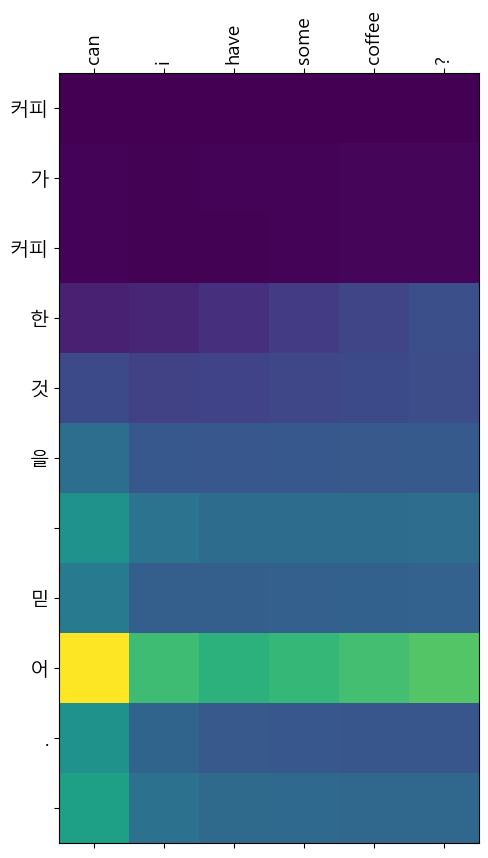

In [188]:
# 실행 예제
translate("Can I have some coffee?", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

Input: learning how to code is fun .
Predicted translation: ['', '어', '떠', '는', '것', '을', '잊지', '', '않', '는', '것', '을', '', '믿', '어', '.', '']


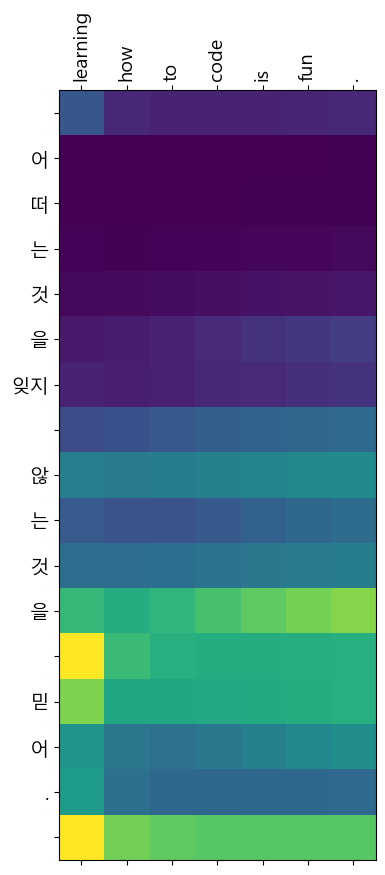

In [189]:
translate("Learning how to code is fun.", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

# 결과

- 구두점 중심의 attention
    - 초기 baseline의 결과 모든 출력 토큰이 문장의 마지막에 오는 구두점을 가장 중요하다 표시한 attention map 생성.
    - 데이터에 문장 부호만 다른 동일한 문장이 여러 개 존재한 것을 그대로 사용하여 이러한 문제가 발생했을 것이라 추정.
    - 문장 부호 제거 후 중복을 제거하려고 보니 데이터 개수가 감소할 것 같아 pre-padding으로 앞쪽 단어들의 영향력을 조금이나마 향상시켜 인지하도록 군형을 맞추고자 하였음.
- pre-padding
    - post-padding으로 진행한 것 보다 결과가 attention map 결과가 좋게 나옴.
- SentencePiece만 사용
- dropout = 0.9
    - dropout 값이 증가할 수록 성능 향상
    - 데이터가 적어 학습이 진행될 수록 과적합이 발생하여 일반화 성능을 높이기 위해 dropout을 매우 강하게 적용.
- emb_dim = 512
- hid_dim = 1024
- lr = 5e-4
    - 1e-3 보다는 안정적으로 수렴함.
    - 1e-3의 경우 train은 0.07, valid는 5.49로 차이가 컸고 10 에폭 이후 train은 계속 감소했으나 valid는 다시 증가하는 추세를 보임.
- Unigram
    - Sentencepiece에서 BPE 모델로 학습한 것 보다 Unigram으로 학습한 것이 attention map 결과가 좋게 나옴. 
    - 통상적으로는 BPE가 더 성능이 좋다고 알려져 있는데 이러한 현상이 생긴 것은 한국어 데이터가 많이 없어서 해당 현상이 발생한 것으로 예상됨.

bpe, with dropout / bpe, with dropout, with pre-padding / unigram, with dropout, with pre-padding

[results_all_in_one.png](result_imgs/results_all_in_one.png)

# 회고

- 과적합이 발생하지 않게 하면서 성능을 향상시키는 방법을 고민하는 것이 어려웠다.
- 다양한 방법을 적용해 보았지만 성능이 원하는 만큼 나오지 않아 아쉽다.
- 추가 실험의 여지가 보여서 추후 더 발전시켜보고 싶다.
- 통상적으로 성능이 좋다고 알려진 조합이 데이터나 모델의 특성에 따라 최적의 조합이 아닐 수도 있다는 것을 알게 되었다.